### Import Modules

In [ ]:
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score

from tqdm import tqdm
import time
import numpy as np
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string

nltk.download('stopwords')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

### Define Global Parameters

In [ ]:
MAX_WORDS = 25
EPOCHS = 15
LEARNING_RATE = 1e-3
BATCH_SIZE = 32
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_HEADS = 5

### Functions for later

In [ ]:
def create_plots(df):

  sns.set(style="whitegrid")

  plt.figure(figsize=(16, 8))

  plt.subplot(1, 3, 1)
  sns.barplot(x='Dataset', y='Test Accuracy', data=df)
  plt.title('Test Accuracy by Dataset')
  plt.xticks(rotation=90)

  plt.subplot(1, 3, 2)
  sns.barplot(x='Dataset', y='Training Time', data=df)
  plt.title('Training Time by Dataset')
  plt.xticks(rotation=90)

  plt.subplot(1, 3, 3)
  sns.barplot(x='Dataset', y='Parameters', data=df)
  plt.title('Model Parameters by Dataset')
  plt.xticks(rotation=90)

  plt.tight_layout()
  plt.show()

### Load & Prepare the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

csv_files = glob.glob(os.path.join('/content/drive/MyDrive/Datasets/Deception/', '*.csv'))

dataframes = {}
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.update({os.path.basename(file).split('.')[0]: df})

tokenizer = get_tokenizer("basic_english")
stop_words = set(stopwords.words('english'))

def yield_tokens(data_iter):
    for text in data_iter:
        tokens = tokenizer(text.lower())  # Convert to lowercase
        tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]  # Remove stopwords and punctuation
        yield tokens

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            tokens = tokenizer(text.lower())  # Convert to lowercase
            tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]  # Remove stopwords and punctuation
            yield tokens


Mounted at /content/drive


In [ ]:
def collate_batch(batch, max_words, vocab):
    Y, X = list(zip(*batch))
    Y = torch.tensor(Y, dtype=torch.long)  # Targets in range [0,1,2,3]
    X = [vocab(tokenizer(text)) for text in X]
    if max_words == -1:
        max_words = max(len(tokens) for tokens in X)
    X = [tokens + ([vocab['<PAD>']] * (max_words - len(tokens))) if len(tokens) < max_words else tokens[:max_words] for tokens in X]
    return torch.tensor(X, dtype=torch.int64).to(device), Y.to(device)

def make_data_loaders(train_dataset, test_dataset, max_words, vocab):
    custom_collate_fn = partial(collate_batch, max_words=max_words, vocab= vocab)

    num_train = int(len(train_dataset) * 0.95)
    split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

    train_loader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
    valid_loader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

    return [train_loader, valid_loader, test_loader]


### RNN Models

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        logits = self.linear(output[:, -1, :])
        return logits



class BiRNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(BiRNNModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        logits = self.linear(output[:, -1, :])  # Use the final output of the RNN for classification
        return logits


class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, (hn, cn) = self.lstm(embeddings)
        logits = self.linear(output[:, -1, :])
        return logits


class GRUModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hn = self.gru(embeddings)
        logits = self.linear(output[:, -1, :])
        return logits


class RNNModel_PreTrained(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, pretrained_embeddings=None):
        super(RNNModel_PreTrained, self).__init__()

        if pretrained_embeddings is not None:
            self.embedding_layer = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        else:
            self.embedding_layer = nn.Embedding(num_embeddings=input_dim, embedding_dim=embedding_dim)

        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        output, hidden = self.rnn(embeddings)
        logits = self.linear(output[:, -1, :])
        return logits

### Attention Models

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads."
        self.head_dim = embed_dim // num_heads
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        # Split the embedding into multiple heads
        queries = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        keys = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        values = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim)

        # Transpose to get dimensions: batch_size, num_heads, seq_len, head_dim
        queries = queries.permute(0, 2, 1, 3)
        keys = keys.permute(0, 2, 1, 3)
        values = values.permute(0, 2, 1, 3)

        # Compute dot product attention scores
        attention_scores = torch.matmul(queries, keys.permute(0, 1, 3, 2)) / np.sqrt(self.head_dim)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Apply dropout
        attention_weights = F.dropout(attention_weights, p=0.1, training=self.training)

        # Weighted sum of values
        weighted_sum = torch.matmul(attention_weights, values)

        # Transpose and reshape to get output
        weighted_sum = weighted_sum.permute(0, 2, 1, 3).contiguous()
        weighted_sum = weighted_sum.view(batch_size, seq_len, embed_dim)

        # Linear layer to get output
        outputs = self.fc_out(weighted_sum)

        return outputs

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.attention = SelfAttention(embed_dim, num_heads)
        self.fc = nn.Linear(embed_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        attention_output = self.attention(embedded)
        hidden = F.relu(self.fc(attention_output))
        output = self.output_layer(hidden[:, -1, :])  # Use only the last hidden state for classification
        return output


In [ ]:
class ImprovedTransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, output_dim, num_layers=2, dropout=0.3):
        super(ImprovedTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, MAX_WORDS, embed_dim))
        self.transformer_layers = nn.ModuleList(
            [SelfAttention(embed_dim, num_heads) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        embedded = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        for attention_layer in self.transformer_layers:
            embedded = self.layer_norm(attention_layer(embedded) + embedded)  # Residual connection
        embedded = self.dropout(embedded)
        hidden = F.relu(self.fc1(embedded))
        output = self.fc2(hidden[:, -1, :])  # Use the last hidden state for classification
        return output


### Train & Evaluation

In [ ]:
def EvaluateModel(model, loss_fn, val_loader):
    model.eval()
    with torch.no_grad():
        Y_actual, Y_preds, losses = [], [], []
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_actual.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_actual = torch.cat(Y_actual)
        Y_preds = torch.cat(Y_preds)

    return torch.tensor(losses).mean(), Y_actual.detach().cpu().numpy(), Y_preds.detach().cpu().numpy()

def TrainModel(model, loss_fn, optimizer, train_loader, valid_loader, epochs, patience):
    best_accuracy = 0.0
    consecutive_no_improvement = 0

    for i in range(1, epochs+1):
        model.train()
        print('Epoch:', i)
        losses = []
        start_time = time.time()
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)
            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_time = time.time() - start_time
        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        valid_loss, valid_actual, valid_preds = EvaluateModel(model, loss_fn, valid_loader)
        print("Valid Loss : {:.3f}".format(valid_loss), "Valid Acc  : {:.3f}".format(accuracy_score(valid_actual, valid_preds)))

        accuracy = accuracy_score(valid_actual, valid_preds)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if consecutive_no_improvement >= patience:
            print(f"Early stopping: No improvement for {patience} consecutive epochs.")
            break

    return train_time


def classification_results(classifier, loaders, patience=float('inf')):
    train_loader, valid_loader, test_loader = loaders

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam([param for param in classifier.parameters() if param.requires_grad], lr=LEARNING_RATE)

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print('\nModel:')
    print(classifier)
    print('Total parameters: ', count_parameters(classifier))
    print('\n\n')

    mean_training_time = TrainModel(classifier, loss_fn, optimizer, train_loader, valid_loader, EPOCHS, patience)

    _, Y_actual, Y_preds = EvaluateModel(classifier, loss_fn, test_loader)

    # Calculate accuracy
    accuracy = accuracy_score(Y_actual, Y_preds)

    # Calculate precision, recall, and F1 score
    precision = precision_score(Y_actual, Y_preds, average='weighted')
    recall = recall_score(Y_actual, Y_preds, average='weighted')
    f1 = f1_score(Y_actual, Y_preds, average='weighted')

    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(Y_actual, Y_preds)

    print("\nTest Accuracy : {:.3f}".format(accuracy))
    print("Precision (Weighted): {:.3f}".format(precision))
    print("Recall (Weighted): {:.3f}".format(recall))
    print("F1-Score (Weighted): {:.3f}".format(f1))
    print("Balanced Accuracy: {:.3f}".format(balanced_acc))

    print("\nClassification Report : ")
    print(classification_report(Y_actual, Y_preds, target_names=['0', '1']))
    print("\nConfusion Matrix : ")
    print(confusion_matrix(Y_actual, Y_preds))

    total_params = count_parameters(classifier)
    print(f'{total_params}, {mean_training_time}, {accuracy}')

    return {
        'Dataset': dataset_name,
        'Parameters': total_params,
        'Training Time': mean_training_time,
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_acc
    }



### Run experiments

In [ ]:
def prepare_data_loaders(dataframes):
    dataset_loaders = {}
    for dname, df in dataframes.items():
        # print(f'..... {dname} ....')
        df['CLASS'] = df['CLASS'].replace({'truthful': 0, 'deceptive': 1})
        # print(df['CLASS'].value_counts())

        X = df['TEXT']
        y = df['CLASS']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

        train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
        test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

        train_dataset = [(label, train_df['TEXT'][i]) for i, label in enumerate(train_df['CLASS'])]
        test_dataset = [(label, test_df['TEXT'][i]) for i, label in enumerate(test_df['CLASS'])]

        vocab = build_vocab_from_iterator(build_vocabulary([train_dataset, test_dataset]), min_freq=10, specials=["<PAD>", "<UNK>"])
        vocab.set_default_index(vocab["<UNK>"])

        loaders = make_data_loaders(train_dataset, test_dataset, MAX_WORDS, vocab)
        dataset_loaders[dname] = (loaders, vocab)

    return dataset_loaders

In [ ]:
dataset_loaders = prepare_data_loaders(dataframes)

In [ ]:
def run_experiment(loaders, model_class, model_name, patience=3, attention=False):
    results_list = []
    for dname, (loaders, vocab) in loaders.items():
        global dataset_name
        dataset_name = dname
        print(vocab)
        if not attention:
            model_instance = model_class(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 2).to(device)
        else:
            model_instance = model_class(len(vocab), EMBEDDING_DIM, NUM_HEADS, HIDDEN_DIM, 2).to(device)

        results = classification_results(model_instance, loaders, patience)
        results_list.append(results)

    results_df = pd.DataFrame(results_list)
    print(f"\nResults DataFrame for {model_name}:")
    print(results_df)
    create_plots(results_df)
    return results_df

Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(1622, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  172954



Epoch: 1


100%|██████████| 38/38 [00:01<00:00, 28.33it/s]


Train Loss : 0.707
Valid Loss : 0.713 Valid Acc  : 0.469
Epoch: 2


100%|██████████| 38/38 [00:00<00:00, 172.94it/s]


Train Loss : 0.677
Valid Loss : 0.718 Valid Acc  : 0.453
Epoch: 3


100%|██████████| 38/38 [00:00<00:00, 155.21it/s]


Train Loss : 0.653
Valid Loss : 0.715 Valid Acc  : 0.484
Epoch: 4


100%|██████████| 38/38 [00:00<00:00, 110.96it/s]


Train Loss : 0.630
Valid Loss : 0.738 Valid Acc  : 0.484
Epoch: 5


100%|██████████| 38/38 [00:00<00:00, 113.94it/s]


Train Loss : 0.594
Valid Loss : 0.717 Valid Acc  : 0.547
Epoch: 6


100%|██████████| 38/38 [00:00<00:00, 112.39it/s]


Train Loss : 0.547
Valid Loss : 0.801 Valid Acc  : 0.531
Epoch: 7


100%|██████████| 38/38 [00:00<00:00, 117.95it/s]


Train Loss : 0.483
Valid Loss : 0.798 Valid Acc  : 0.578
Epoch: 8


100%|██████████| 38/38 [00:00<00:00, 108.47it/s]


Train Loss : 0.412
Valid Loss : 0.747 Valid Acc  : 0.656
Epoch: 9


100%|██████████| 38/38 [00:00<00:00, 118.12it/s]


Train Loss : 0.342
Valid Loss : 0.810 Valid Acc  : 0.641
Epoch: 10


100%|██████████| 38/38 [00:00<00:00, 106.82it/s]


Train Loss : 0.277
Valid Loss : 0.989 Valid Acc  : 0.641
Epoch: 11


100%|██████████| 38/38 [00:00<00:00, 101.54it/s]


Train Loss : 0.228
Valid Loss : 1.011 Valid Acc  : 0.625
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.487
Precision (Weighted): 0.487
Recall (Weighted): 0.487
F1-Score (Weighted): 0.481
Balanced Accuracy: 0.487

Classification Report : 
              precision    recall  f1-score   support

           0       0.49      0.60      0.54       160
           1       0.48      0.38      0.42       160

    accuracy                           0.49       320
   macro avg       0.49      0.49      0.48       320
weighted avg       0.49      0.49      0.48       320


Confusion Matrix : 
[[ 96  64]
 [100  60]]
172954, 0.3836240768432617, 0.4875
Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(84, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  19154



Epoch: 1


100%|██████████| 3/3 [00:00<00:00, 131.00it/s]


Train Loss : 0.737
Valid Loss : 0.584 Valid Acc  : 0.800
Epoch: 2


100%|██████████| 3/3 [00:00<00:00, 147.12it/s]


Train Loss : 0.690
Valid Loss : 0.628 Valid Acc  : 0.400
Epoch: 3


100%|██████████| 3/3 [00:00<00:00, 142.91it/s]


Train Loss : 0.662
Valid Loss : 0.652 Valid Acc  : 0.400
Epoch: 4


100%|██████████| 3/3 [00:00<00:00, 143.20it/s]


Train Loss : 0.666
Valid Loss : 0.698 Valid Acc  : 0.400
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.591
Precision (Weighted): 0.775
Recall (Weighted): 0.591
F1-Score (Weighted): 0.509
Balanced Accuracy: 0.591

Classification Report : 
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       1.00      0.18      0.31        11

    accuracy                           0.59        22
   macro avg       0.78      0.59      0.51        22
weighted avg       0.78      0.59      0.51        22


Confusion Matrix : 
[[11  0]
 [ 9  2]]
19154, 0.0316314697265625, 0.5909090909090909
Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(280, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  38754



Epoch: 1


100%|██████████| 6/6 [00:00<00:00, 135.67it/s]


Train Loss : 0.707
Valid Loss : 0.622 Valid Acc  : 0.800
Epoch: 2


100%|██████████| 6/6 [00:00<00:00, 125.32it/s]


Train Loss : 0.669
Valid Loss : 0.613 Valid Acc  : 0.600
Epoch: 3


100%|██████████| 6/6 [00:00<00:00, 120.24it/s]


Train Loss : 0.655
Valid Loss : 0.611 Valid Acc  : 0.600
Epoch: 4


100%|██████████| 6/6 [00:00<00:00, 116.46it/s]


Train Loss : 0.627
Valid Loss : 0.565 Valid Acc  : 0.900
Epoch: 5


100%|██████████| 6/6 [00:00<00:00, 110.09it/s]


Train Loss : 0.612
Valid Loss : 0.614 Valid Acc  : 0.700
Epoch: 6


100%|██████████| 6/6 [00:00<00:00, 83.80it/s]


Train Loss : 0.592
Valid Loss : 0.607 Valid Acc  : 0.700
Epoch: 7


100%|██████████| 6/6 [00:00<00:00, 88.93it/s]


Train Loss : 0.572
Valid Loss : 0.553 Valid Acc  : 0.900
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.521
Precision (Weighted): 0.524
Recall (Weighted): 0.521
F1-Score (Weighted): 0.503
Balanced Accuracy: 0.521

Classification Report : 
              precision    recall  f1-score   support

           0       0.53      0.33      0.41        24
           1       0.52      0.71      0.60        24

    accuracy                           0.52        48
   macro avg       0.52      0.52      0.50        48
weighted avg       0.52      0.52      0.50        48


Confusion Matrix : 
[[ 8 16]
 [ 7 17]]
38754, 0.0830831527709961, 0.5208333333333334
Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(6675, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  678254



Epoch: 1


100%|██████████| 499/499 [00:02<00:00, 237.49it/s]


Train Loss : 0.700
Valid Loss : 0.691 Valid Acc  : 0.537
Epoch: 2


100%|██████████| 499/499 [00:01<00:00, 255.34it/s]


Train Loss : 0.688
Valid Loss : 0.696 Valid Acc  : 0.511
Epoch: 3


100%|██████████| 499/499 [00:02<00:00, 248.15it/s]


Train Loss : 0.678
Valid Loss : 0.706 Valid Acc  : 0.493
Epoch: 4


100%|██████████| 499/499 [00:01<00:00, 253.96it/s]


Train Loss : 0.660
Valid Loss : 0.715 Valid Acc  : 0.501
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.506
Precision (Weighted): 0.508
Recall (Weighted): 0.506
F1-Score (Weighted): 0.475
Balanced Accuracy: 0.506

Classification Report : 
              precision    recall  f1-score   support

           0       0.50      0.75      0.60      2100
           1       0.51      0.26      0.35      2100

    accuracy                           0.51      4200
   macro avg       0.51      0.51      0.47      4200
weighted avg       0.51      0.51      0.47      4200


Confusion Matrix : 
[[1579  521]
 [1552  548]]
678254, 1.9732580184936523, 0.5064285714285715
Vocab()

Model:
RNNModel(
  (embedding_layer): Embedding(368, 100)
  (rnn): RNN(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  47554



Epoch: 1


100%|██████████| 15/15 [00:00<00:00, 266.23it/s]


Train Loss : 0.724
Valid Loss : 0.714 Valid Acc  : 0.480
Epoch: 2


100%|██████████| 15/15 [00:00<00:00, 239.88it/s]


Train Loss : 0.700
Valid Loss : 0.729 Valid Acc  : 0.240
Epoch: 3


100%|██████████| 15/15 [00:00<00:00, 258.30it/s]


Train Loss : 0.656
Valid Loss : 0.718 Valid Acc  : 0.440
Epoch: 4


100%|██████████| 15/15 [00:00<00:00, 249.32it/s]


Train Loss : 0.634
Valid Loss : 0.708 Valid Acc  : 0.560
Epoch: 5


100%|██████████| 15/15 [00:00<00:00, 255.46it/s]


Train Loss : 0.598
Valid Loss : 0.747 Valid Acc  : 0.320
Epoch: 6


100%|██████████| 15/15 [00:00<00:00, 260.85it/s]


Train Loss : 0.573
Valid Loss : 0.805 Valid Acc  : 0.440
Epoch: 7


100%|██████████| 15/15 [00:00<00:00, 245.51it/s]


Train Loss : 0.525
Valid Loss : 0.797 Valid Acc  : 0.360
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.521
Precision (Weighted): 0.521
Recall (Weighted): 0.521
F1-Score (Weighted): 0.517
Balanced Accuracy: 0.520

Classification Report : 
              precision    recall  f1-score   support

           0       0.52      0.43      0.47        60
           1       0.52      0.61      0.56        61

    accuracy                           0.52       121
   macro avg       0.52      0.52      0.52       121
weighted avg       0.52      0.52      0.52       121


Confusion Matrix : 
[[26 34]
 [24 37]]
47554, 0.07169628143310547, 0.5206611570247934

Results DataFrame for RNN Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      172954       0.383624       0.487500   
1  Restaurants_Reviews_Dataset       19154       0.031631       0.590909   
2                DeRev_Dataset       38754       0.08308

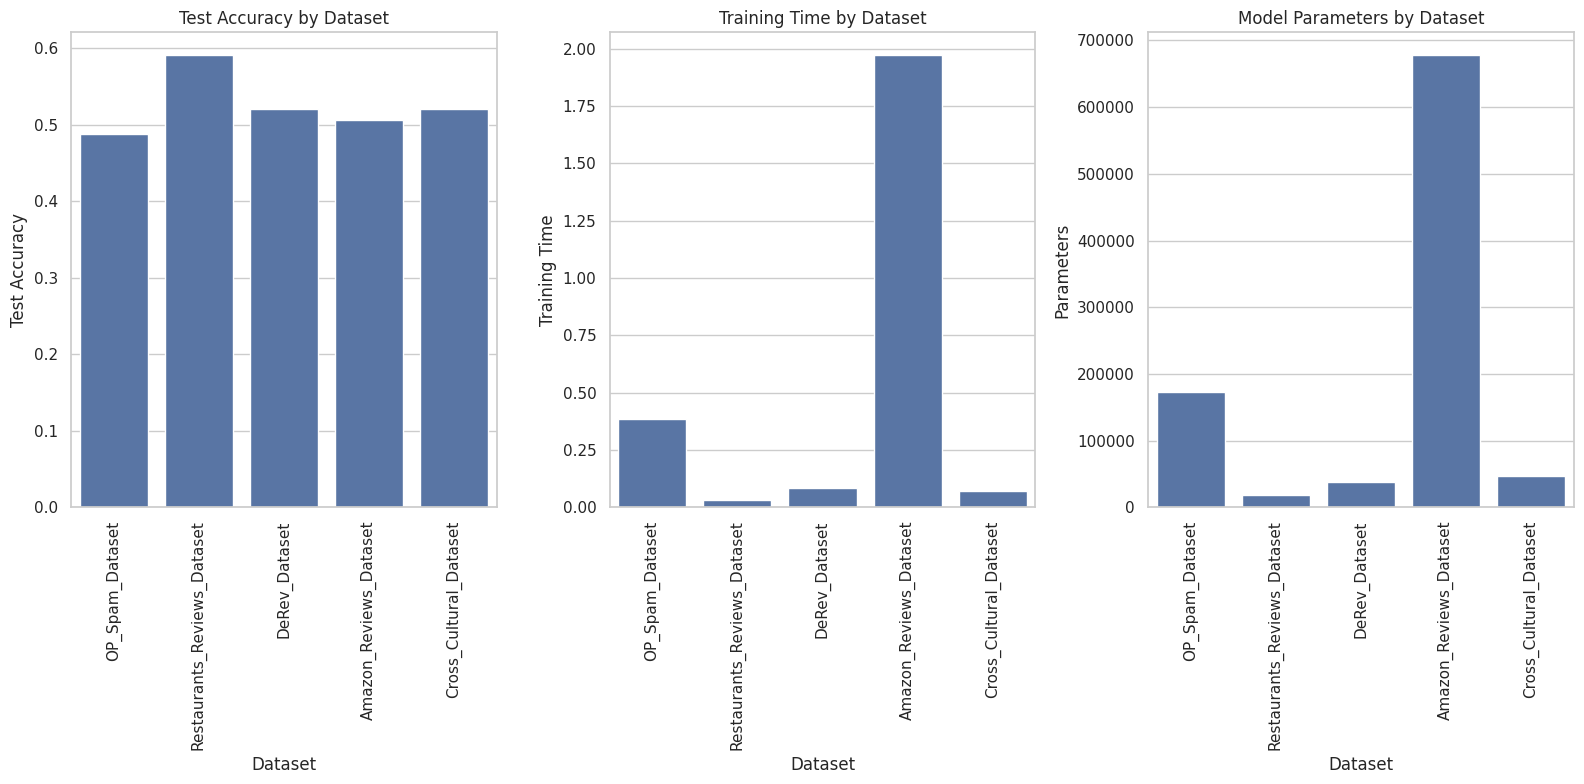

Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(1622, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  183706



Epoch: 1


100%|██████████| 38/38 [00:00<00:00, 134.84it/s]


Train Loss : 0.708
Valid Loss : 0.691 Valid Acc  : 0.594
Epoch: 2


100%|██████████| 38/38 [00:00<00:00, 108.45it/s]


Train Loss : 0.680
Valid Loss : 0.685 Valid Acc  : 0.562
Epoch: 3


100%|██████████| 38/38 [00:00<00:00, 114.60it/s]


Train Loss : 0.667
Valid Loss : 0.747 Valid Acc  : 0.422
Epoch: 4


100%|██████████| 38/38 [00:00<00:00, 106.34it/s]


Train Loss : 0.635
Valid Loss : 0.791 Valid Acc  : 0.453
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.525
Precision (Weighted): 0.540
Recall (Weighted): 0.525
F1-Score (Weighted): 0.476
Balanced Accuracy: 0.525

Classification Report : 
              precision    recall  f1-score   support

           0       0.52      0.83      0.64       160
           1       0.56      0.22      0.32       160

    accuracy                           0.53       320
   macro avg       0.54      0.53      0.48       320
weighted avg       0.54      0.53      0.48       320


Confusion Matrix : 
[[133  27]
 [125  35]]
183706, 0.36449766159057617, 0.525
Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(84, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  29906



Epoch: 1


100%|██████████| 3/3 [00:00<00:00, 102.90it/s]


Train Loss : 0.699
Valid Loss : 0.803 Valid Acc  : 0.200
Epoch: 2


100%|██████████| 3/3 [00:00<00:00, 118.86it/s]


Train Loss : 0.649
Valid Loss : 0.768 Valid Acc  : 0.600
Epoch: 3


100%|██████████| 3/3 [00:00<00:00, 112.42it/s]


Train Loss : 0.644
Valid Loss : 0.801 Valid Acc  : 0.200
Epoch: 4


100%|██████████| 3/3 [00:00<00:00, 108.78it/s]


Train Loss : 0.618
Valid Loss : 0.808 Valid Acc  : 0.200
Epoch: 5


100%|██████████| 3/3 [00:00<00:00, 102.92it/s]


Train Loss : 0.611
Valid Loss : 0.817 Valid Acc  : 0.200
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.727
Precision (Weighted): 0.824
Recall (Weighted): 0.727
F1-Score (Weighted): 0.705
Balanced Accuracy: 0.727

Classification Report : 
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       1.00      0.45      0.62        11

    accuracy                           0.73        22
   macro avg       0.82      0.73      0.71        22
weighted avg       0.82      0.73      0.71        22


Confusion Matrix : 
[[11  0]
 [ 6  5]]
29906, 0.03764057159423828, 0.7272727272727273
Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(280, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  49506



Epoch: 1


100%|██████████| 6/6 [00:00<00:00, 126.10it/s]


Train Loss : 0.716
Valid Loss : 0.710 Valid Acc  : 0.400
Epoch: 2


100%|██████████| 6/6 [00:00<00:00, 105.04it/s]


Train Loss : 0.672
Valid Loss : 0.659 Valid Acc  : 0.600
Epoch: 3


100%|██████████| 6/6 [00:00<00:00, 104.88it/s]


Train Loss : 0.642
Valid Loss : 0.612 Valid Acc  : 0.600
Epoch: 4


100%|██████████| 6/6 [00:00<00:00, 129.88it/s]

Train Loss : 0.632


Valid Loss : 0.636 Valid Acc  : 0.700
Epoch: 5


100%|██████████| 6/6 [00:00<00:00, 121.95it/s]


Train Loss : 0.614
Valid Loss : 0.661 Valid Acc  : 0.500
Epoch: 6


100%|██████████| 6/6 [00:00<00:00, 121.74it/s]


Train Loss : 0.597
Valid Loss : 0.621 Valid Acc  : 0.700
Epoch: 7


100%|██████████| 6/6 [00:00<00:00, 111.32it/s]


Train Loss : 0.586
Valid Loss : 0.618 Valid Acc  : 0.800
Epoch: 8


100%|██████████| 6/6 [00:00<00:00, 107.28it/s]


Train Loss : 0.563
Valid Loss : 0.614 Valid Acc  : 0.700
Epoch: 9


100%|██████████| 6/6 [00:00<00:00, 128.52it/s]

Train Loss : 0.563
Valid Loss : 0.614

 Valid Acc  : 0.800
Epoch: 10


100%|██████████| 6/6 [00:00<00:00, 123.36it/s]


Train Loss : 0.539
Valid Loss : 0.586 Valid Acc  : 0.700
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.604
Precision (Weighted): 0.614
Recall (Weighted): 0.604
F1-Score (Weighted): 0.596
Balanced Accuracy: 0.604

Classification Report : 
              precision    recall  f1-score   support

           0       0.65      0.46      0.54        24
           1       0.58      0.75      0.65        24

    accuracy                           0.60        48
   macro avg       0.61      0.60      0.60        48
weighted avg       0.61      0.60      0.60        48


Confusion Matrix : 
[[11 13]
 [ 6 18]]
49506, 0.05477499961853027, 0.6041666666666666
Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(6675, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  689006



Epoch: 1


100%|██████████| 499/499 [00:02<00:00, 169.80it/s]


Train Loss : 0.700
Valid Loss : 0.695 Valid Acc  : 0.525
Epoch: 2


100%|██████████| 499/499 [00:02<00:00, 237.80it/s]


Train Loss : 0.689
Valid Loss : 0.695 Valid Acc  : 0.524
Epoch: 3


100%|██████████| 499/499 [00:02<00:00, 235.51it/s]


Train Loss : 0.678
Valid Loss : 0.711 Valid Acc  : 0.487
Epoch: 4


100%|██████████| 499/499 [00:02<00:00, 238.77it/s]


Train Loss : 0.657
Valid Loss : 0.732 Valid Acc  : 0.519
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.533
Precision (Weighted): 0.535
Recall (Weighted): 0.533
F1-Score (Weighted): 0.528
Balanced Accuracy: 0.533

Classification Report : 
              precision    recall  f1-score   support

           0       0.53      0.64      0.58      2100
           1       0.54      0.43      0.48      2100

    accuracy                           0.53      4200
   macro avg       0.53      0.53      0.53      4200
weighted avg       0.53      0.53      0.53      4200


Confusion Matrix : 
[[1335  765]
 [1196  904]]
689006, 2.096853733062744, 0.5330952380952381
Vocab()

Model:
BiRNNModel(
  (embedding_layer): Embedding(368, 100)
  (rnn): RNN(100, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Total parameters:  58306



Epoch: 1


100%|██████████| 15/15 [00:00<00:00, 207.49it/s]


Train Loss : 0.704
Valid Loss : 0.713 Valid Acc  : 0.520
Epoch: 2


100%|██████████| 15/15 [00:00<00:00, 235.36it/s]


Train Loss : 0.671
Valid Loss : 0.701 Valid Acc  : 0.480
Epoch: 3


100%|██████████| 15/15 [00:00<00:00, 217.31it/s]


Train Loss : 0.630
Valid Loss : 0.684 Valid Acc  : 0.480
Epoch: 4


100%|██████████| 15/15 [00:00<00:00, 193.82it/s]


Train Loss : 0.612
Valid Loss : 0.712 Valid Acc  : 0.480
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.471
Precision (Weighted): 0.446
Recall (Weighted): 0.471
F1-Score (Weighted): 0.393
Balanced Accuracy: 0.474

Classification Report : 
              precision    recall  f1-score   support

           0       0.48      0.83      0.61        60
           1       0.41      0.11      0.18        61

    accuracy                           0.47       121
   macro avg       0.45      0.47      0.39       121
weighted avg       0.45      0.47      0.39       121


Confusion Matrix : 
[[50 10]
 [54  7]]
58306, 0.08401107788085938, 0.47107438016528924

Results DataFrame for BiRNN Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      183706       0.364498       0.525000   
1  Restaurants_Reviews_Dataset       29906       0.037641       0.727273   
2                DeRev_Dataset       49506       0.05

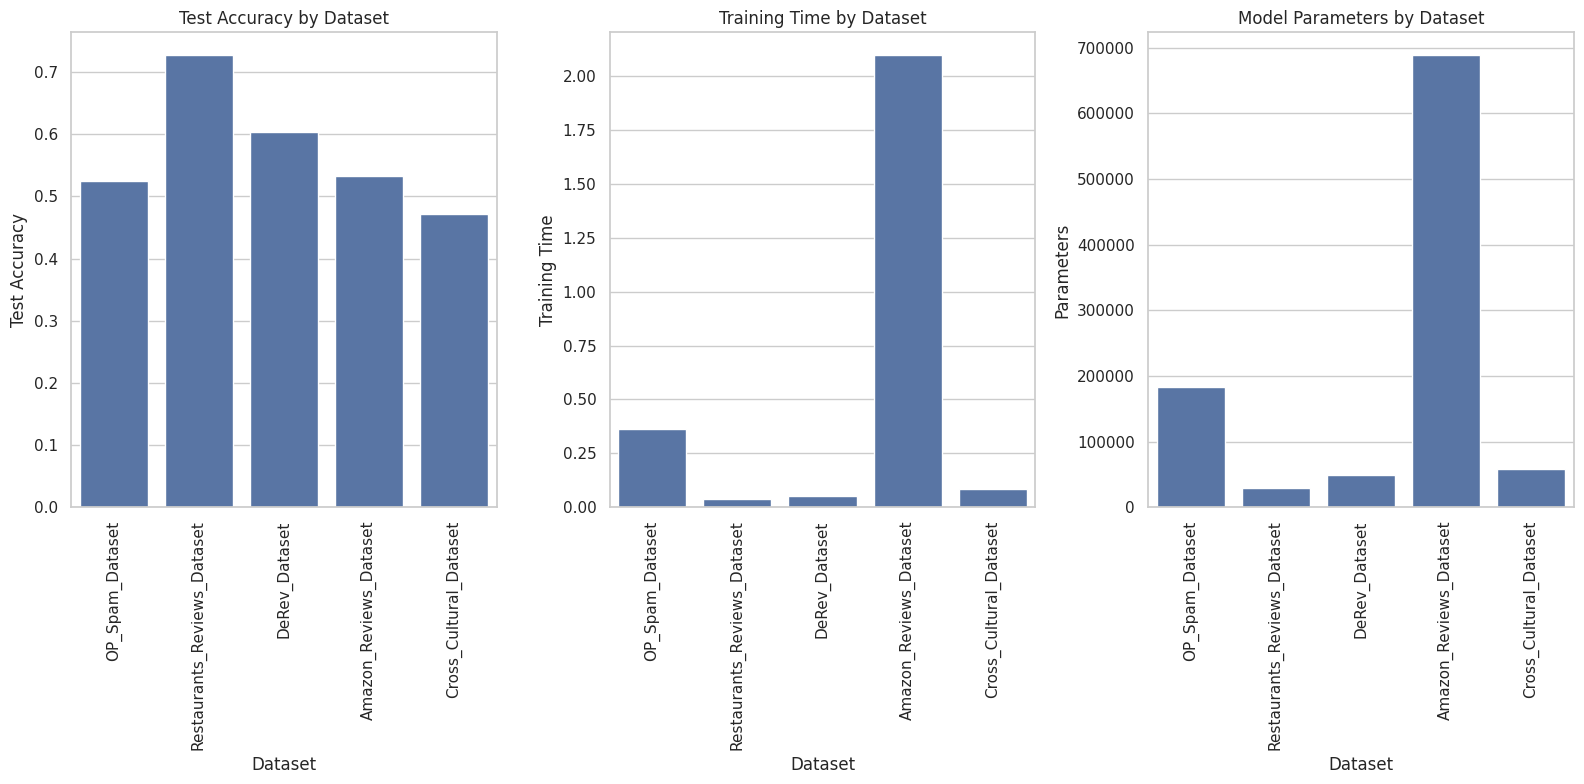

Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(1622, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  204826



Epoch: 1


100%|██████████| 38/38 [00:00<00:00, 167.84it/s]


Train Loss : 0.700
Valid Loss : 0.686 Valid Acc  : 0.562
Epoch: 2


100%|██████████| 38/38 [00:00<00:00, 166.87it/s]


Train Loss : 0.687
Valid Loss : 0.696 Valid Acc  : 0.469
Epoch: 3


100%|██████████| 38/38 [00:00<00:00, 173.24it/s]


Train Loss : 0.675
Valid Loss : 0.684 Valid Acc  : 0.594
Epoch: 4


100%|██████████| 38/38 [00:00<00:00, 144.12it/s]


Train Loss : 0.634
Valid Loss : 0.620 Valid Acc  : 0.641
Epoch: 5


100%|██████████| 38/38 [00:00<00:00, 139.81it/s]


Train Loss : 0.512
Valid Loss : 0.605 Valid Acc  : 0.672
Epoch: 6


100%|██████████| 38/38 [00:00<00:00, 115.24it/s]


Train Loss : 0.399
Valid Loss : 0.644 Valid Acc  : 0.688
Epoch: 7


100%|██████████| 38/38 [00:00<00:00, 111.74it/s]


Train Loss : 0.320
Valid Loss : 0.721 Valid Acc  : 0.703
Epoch: 8


100%|██████████| 38/38 [00:00<00:00, 117.43it/s]


Train Loss : 0.227
Valid Loss : 0.828 Valid Acc  : 0.672
Epoch: 9


100%|██████████| 38/38 [00:00<00:00, 115.07it/s]


Train Loss : 0.181
Valid Loss : 0.926 Valid Acc  : 0.672
Epoch: 10


100%|██████████| 38/38 [00:00<00:00, 107.55it/s]


Train Loss : 0.115
Valid Loss : 1.018 Valid Acc  : 0.672
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.709
Precision (Weighted): 0.711
Recall (Weighted): 0.709
F1-Score (Weighted): 0.709
Balanced Accuracy: 0.709

Classification Report : 
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       160
           1       0.69      0.75      0.72       160

    accuracy                           0.71       320
   macro avg       0.71      0.71      0.71       320
weighted avg       0.71      0.71      0.71       320


Confusion Matrix : 
[[107  53]
 [ 40 120]]
204826, 0.36192965507507324, 0.709375
Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(84, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  51026



Epoch: 1


100%|██████████| 3/3 [00:00<00:00, 151.06it/s]


Train Loss : 0.694
Valid Loss : 0.743 Valid Acc  : 0.200
Epoch: 2


100%|██████████| 3/3 [00:00<00:00, 150.57it/s]


Train Loss : 0.672
Valid Loss : 0.700 Valid Acc  : 0.600
Epoch: 3


100%|██████████| 3/3 [00:00<00:00, 156.35it/s]


Train Loss : 0.668
Valid Loss : 0.725 Valid Acc  : 0.200
Epoch: 4


100%|██████████| 3/3 [00:00<00:00, 166.72it/s]


Train Loss : 0.648
Valid Loss : 0.723 Valid Acc  : 0.200
Epoch: 5


100%|██████████| 3/3 [00:00<00:00, 163.44it/s]


Train Loss : 0.645
Valid Loss : 0.726 Valid Acc  : 0.200
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.591
Precision (Weighted): 0.653
Recall (Weighted): 0.591
F1-Score (Weighted): 0.545
Balanced Accuracy: 0.591

Classification Report : 
              precision    recall  f1-score   support

           0       0.56      0.91      0.69        11
           1       0.75      0.27      0.40        11

    accuracy                           0.59        22
   macro avg       0.65      0.59      0.54        22
weighted avg       0.65      0.59      0.54        22


Confusion Matrix : 
[[10  1]
 [ 8  3]]
51026, 0.024877071380615234, 0.5909090909090909
Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(280, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  70626



Epoch: 1


100%|██████████| 6/6 [00:00<00:00, 124.24it/s]


Train Loss : 0.710
Valid Loss : 0.664 Valid Acc  : 0.700
Epoch: 2


100%|██████████| 6/6 [00:00<00:00, 123.13it/s]


Train Loss : 0.685
Valid Loss : 0.628 Valid Acc  : 0.700
Epoch: 3


100%|██████████| 6/6 [00:00<00:00, 120.26it/s]


Train Loss : 0.677
Valid Loss : 0.639 Valid Acc  : 0.800
Epoch: 4


100%|██████████| 6/6 [00:00<00:00, 138.74it/s]


Train Loss : 0.673
Valid Loss : 0.670 Valid Acc  : 0.400
Epoch: 5


100%|██████████| 6/6 [00:00<00:00, 123.03it/s]


Train Loss : 0.664
Valid Loss : 0.614 Valid Acc  : 0.800
Epoch: 6


100%|██████████| 6/6 [00:00<00:00, 107.11it/s]


Train Loss : 0.652
Valid Loss : 0.646 Valid Acc  : 0.700
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.562
Precision (Weighted): 0.568
Recall (Weighted): 0.562
F1-Score (Weighted): 0.553
Balanced Accuracy: 0.562

Classification Report : 
              precision    recall  f1-score   support

           0       0.55      0.71      0.62        24
           1       0.59      0.42      0.49        24

    accuracy                           0.56        48
   macro avg       0.57      0.56      0.55        48
weighted avg       0.57      0.56      0.55        48


Confusion Matrix : 
[[17  7]
 [14 10]]
70626, 0.06316423416137695, 0.5625
Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(6675, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  710126



Epoch: 1


100%|██████████| 499/499 [00:02<00:00, 177.75it/s]


Train Loss : 0.692
Valid Loss : 0.692 Valid Acc  : 0.539
Epoch: 2


100%|██████████| 499/499 [00:02<00:00, 234.66it/s]


Train Loss : 0.671
Valid Loss : 0.682 Valid Acc  : 0.594
Epoch: 3


100%|██████████| 499/499 [00:02<00:00, 240.83it/s]


Train Loss : 0.616
Valid Loss : 0.691 Valid Acc  : 0.594
Epoch: 4


100%|██████████| 499/499 [00:02<00:00, 240.96it/s]


Train Loss : 0.539
Valid Loss : 0.738 Valid Acc  : 0.604
Epoch: 5


100%|██████████| 499/499 [00:02<00:00, 236.38it/s]


Train Loss : 0.451
Valid Loss : 0.812 Valid Acc  : 0.582
Epoch: 6


100%|██████████| 499/499 [00:02<00:00, 186.02it/s]


Train Loss : 0.350
Valid Loss : 0.995 Valid Acc  : 0.570
Epoch: 7


100%|██████████| 499/499 [00:02<00:00, 179.88it/s]


Train Loss : 0.250
Valid Loss : 1.200 Valid Acc  : 0.558
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.561
Precision (Weighted): 0.561
Recall (Weighted): 0.561
F1-Score (Weighted): 0.561
Balanced Accuracy: 0.561

Classification Report : 
              precision    recall  f1-score   support

           0       0.56      0.56      0.56      2100
           1       0.56      0.57      0.56      2100

    accuracy                           0.56      4200
   macro avg       0.56      0.56      0.56      4200
weighted avg       0.56      0.56      0.56      4200


Confusion Matrix : 
[[1168  932]
 [ 910 1190]]
710126, 2.783757448196411, 0.5614285714285714
Vocab()

Model:
LSTMModel(
  (embedding_layer): Embedding(368, 100)
  (lstm): LSTM(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  79426



Epoch: 1


100%|██████████| 15/15 [00:00<00:00, 228.46it/s]


Train Loss : 0.694
Valid Loss : 0.703 Valid Acc  : 0.520
Epoch: 2


100%|██████████| 15/15 [00:00<00:00, 234.81it/s]


Train Loss : 0.677
Valid Loss : 0.707 Valid Acc  : 0.480
Epoch: 3


100%|██████████| 15/15 [00:00<00:00, 169.95it/s]


Train Loss : 0.665
Valid Loss : 0.718 Valid Acc  : 0.400
Epoch: 4


100%|██████████| 15/15 [00:00<00:00, 191.48it/s]


Train Loss : 0.639
Valid Loss : 0.714 Valid Acc  : 0.520
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.529
Precision (Weighted): 0.540
Recall (Weighted): 0.529
F1-Score (Weighted): 0.484
Balanced Accuracy: 0.527

Classification Report : 
              precision    recall  f1-score   support

           0       0.56      0.23      0.33        60
           1       0.52      0.82      0.64        61

    accuracy                           0.53       121
   macro avg       0.54      0.53      0.48       121
weighted avg       0.54      0.53      0.48       121


Confusion Matrix : 
[[14 46]
 [11 50]]
79426, 0.08789920806884766, 0.5289256198347108

Results DataFrame for LSTM Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      204826       0.361930       0.709375   
1  Restaurants_Reviews_Dataset       51026       0.024877       0.590909   
2                DeRev_Dataset       70626       0.0631

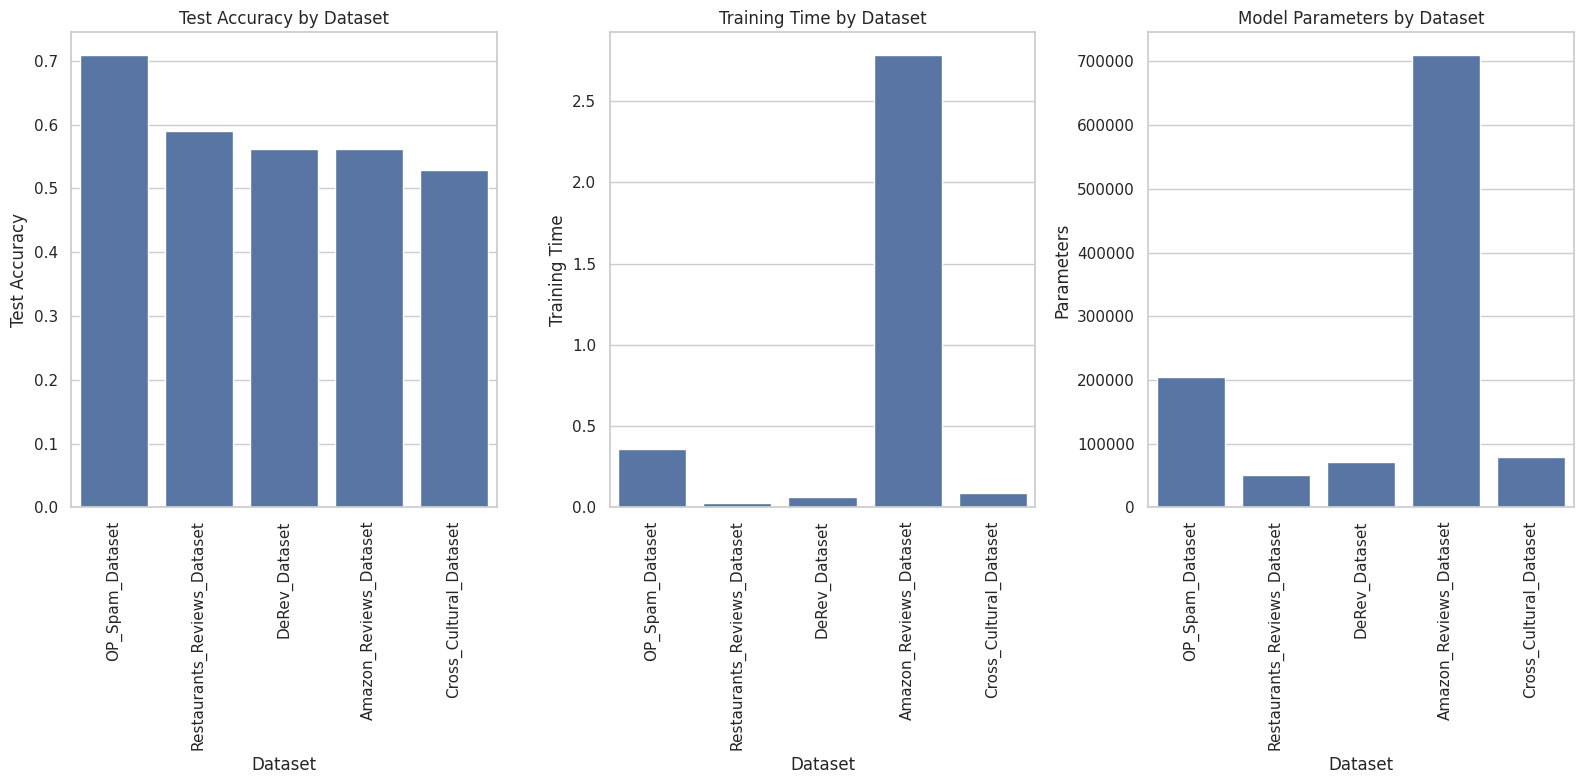

Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(1622, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  194202



Epoch: 1


100%|██████████| 38/38 [00:00<00:00, 152.26it/s]


Train Loss : 0.701
Valid Loss : 0.712 Valid Acc  : 0.484
Epoch: 2


100%|██████████| 38/38 [00:00<00:00, 164.14it/s]


Train Loss : 0.670
Valid Loss : 0.681 Valid Acc  : 0.578
Epoch: 3


100%|██████████| 38/38 [00:00<00:00, 164.10it/s]


Train Loss : 0.604
Valid Loss : 0.651 Valid Acc  : 0.641
Epoch: 4


100%|██████████| 38/38 [00:00<00:00, 171.00it/s]


Train Loss : 0.463
Valid Loss : 0.570 Valid Acc  : 0.656
Epoch: 5


100%|██████████| 38/38 [00:00<00:00, 135.36it/s]


Train Loss : 0.357
Valid Loss : 0.548 Valid Acc  : 0.703
Epoch: 6


100%|██████████| 38/38 [00:00<00:00, 167.41it/s]


Train Loss : 0.277
Valid Loss : 0.588 Valid Acc  : 0.656
Epoch: 7


100%|██████████| 38/38 [00:00<00:00, 163.36it/s]


Train Loss : 0.198
Valid Loss : 0.614 Valid Acc  : 0.719
Epoch: 8


100%|██████████| 38/38 [00:00<00:00, 164.45it/s]


Train Loss : 0.147
Valid Loss : 0.719 Valid Acc  : 0.750
Epoch: 9


100%|██████████| 38/38 [00:00<00:00, 150.19it/s]


Train Loss : 0.086
Valid Loss : 0.797 Valid Acc  : 0.734
Epoch: 10


100%|██████████| 38/38 [00:00<00:00, 169.13it/s]


Train Loss : 0.065
Valid Loss : 1.002 Valid Acc  : 0.734
Epoch: 11


100%|██████████| 38/38 [00:00<00:00, 164.15it/s]


Train Loss : 0.035
Valid Loss : 1.018 Valid Acc  : 0.750
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.731
Precision (Weighted): 0.750
Recall (Weighted): 0.731
F1-Score (Weighted): 0.726
Balanced Accuracy: 0.731

Classification Report : 
              precision    recall  f1-score   support

           0       0.82      0.59      0.69       160
           1       0.68      0.87      0.76       160

    accuracy                           0.73       320
   macro avg       0.75      0.73      0.73       320
weighted avg       0.75      0.73      0.73       320


Confusion Matrix : 
[[ 95  65]
 [ 21 139]]
194202, 0.23786592483520508, 0.73125
Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(84, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  40402



Epoch: 1


100%|██████████| 3/3 [00:00<00:00, 156.19it/s]


Train Loss : 0.739
Valid Loss : 0.668 Valid Acc  : 0.600
Epoch: 2


100%|██████████| 3/3 [00:00<00:00, 140.90it/s]


Train Loss : 0.659
Valid Loss : 0.794 Valid Acc  : 0.200
Epoch: 3


100%|██████████| 3/3 [00:00<00:00, 153.96it/s]


Train Loss : 0.680
Valid Loss : 0.858 Valid Acc  : 0.200
Epoch: 4


100%|██████████| 3/3 [00:00<00:00, 136.50it/s]


Train Loss : 0.660
Valid Loss : 0.791 Valid Acc  : 0.200
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.545
Precision (Weighted): 0.762
Recall (Weighted): 0.545
F1-Score (Weighted): 0.427
Balanced Accuracy: 0.545

Classification Report : 
              precision    recall  f1-score   support

           0       0.52      1.00      0.69        11
           1       1.00      0.09      0.17        11

    accuracy                           0.55        22
   macro avg       0.76      0.55      0.43        22
weighted avg       0.76      0.55      0.43        22


Confusion Matrix : 
[[11  0]
 [10  1]]
40402, 0.029639244079589844, 0.5454545454545454
Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(280, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  60002



Epoch: 1


100%|██████████| 6/6 [00:00<00:00, 115.08it/s]


Train Loss : 0.692
Valid Loss : 0.669 Valid Acc  : 0.700
Epoch: 2


100%|██████████| 6/6 [00:00<00:00, 153.58it/s]


Train Loss : 0.675
Valid Loss : 0.620 Valid Acc  : 0.800
Epoch: 3


100%|██████████| 6/6 [00:00<00:00, 112.62it/s]


Train Loss : 0.640
Valid Loss : 0.702 Valid Acc  : 0.300
Epoch: 4


100%|██████████| 6/6 [00:00<00:00, 142.41it/s]


Train Loss : 0.635
Valid Loss : 0.690 Valid Acc  : 0.300
Epoch: 5


100%|██████████| 6/6 [00:00<00:00, 141.91it/s]


Train Loss : 0.612
Valid Loss : 0.615 Valid Acc  : 0.800
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.542
Precision (Weighted): 0.575
Recall (Weighted): 0.542
F1-Score (Weighted): 0.484
Balanced Accuracy: 0.542

Classification Report : 
              precision    recall  f1-score   support

           0       0.62      0.21      0.31        24
           1       0.53      0.88      0.66        24

    accuracy                           0.54        48
   macro avg       0.57      0.54      0.48        48
weighted avg       0.58      0.54      0.48        48


Confusion Matrix : 
[[ 5 19]
 [ 3 21]]
60002, 0.04822802543640137, 0.5416666666666666
Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(6675, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  699502



Epoch: 1


100%|██████████| 499/499 [00:02<00:00, 245.94it/s]


Train Loss : 0.694
Valid Loss : 0.692 Valid Acc  : 0.524
Epoch: 2


100%|██████████| 499/499 [00:02<00:00, 224.97it/s]


Train Loss : 0.674
Valid Loss : 0.688 Valid Acc  : 0.570
Epoch: 3


100%|██████████| 499/499 [00:03<00:00, 162.54it/s]


Train Loss : 0.624
Valid Loss : 0.705 Valid Acc  : 0.549
Epoch: 4


100%|██████████| 499/499 [00:02<00:00, 248.16it/s]


Train Loss : 0.549
Valid Loss : 0.753 Valid Acc  : 0.574
Epoch: 5


100%|██████████| 499/499 [00:02<00:00, 237.68it/s]


Train Loss : 0.449
Valid Loss : 0.877 Valid Acc  : 0.557
Epoch: 6


100%|██████████| 499/499 [00:02<00:00, 183.22it/s]


Train Loss : 0.325
Valid Loss : 1.026 Valid Acc  : 0.567
Epoch: 7


100%|██████████| 499/499 [00:03<00:00, 157.94it/s]


Train Loss : 0.201
Valid Loss : 1.334 Valid Acc  : 0.552
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.582
Precision (Weighted): 0.582
Recall (Weighted): 0.582
F1-Score (Weighted): 0.582
Balanced Accuracy: 0.582

Classification Report : 
              precision    recall  f1-score   support

           0       0.58      0.58      0.58      2100
           1       0.58      0.59      0.58      2100

    accuracy                           0.58      4200
   macro avg       0.58      0.58      0.58      4200
weighted avg       0.58      0.58      0.58      4200


Confusion Matrix : 
[[1210  890]
 [ 864 1236]]
699502, 3.1791160106658936, 0.5823809523809523
Vocab()

Model:
GRUModel(
  (embedding_layer): Embedding(368, 100)
  (gru): GRU(100, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  68802



Epoch: 1


100%|██████████| 15/15 [00:00<00:00, 164.10it/s]


Train Loss : 0.715
Valid Loss : 0.718 Valid Acc  : 0.440
Epoch: 2


100%|██████████| 15/15 [00:00<00:00, 177.95it/s]


Train Loss : 0.689
Valid Loss : 0.698 Valid Acc  : 0.520
Epoch: 3


100%|██████████| 15/15 [00:00<00:00, 172.69it/s]


Train Loss : 0.668
Valid Loss : 0.696 Valid Acc  : 0.480
Epoch: 4


100%|██████████| 15/15 [00:00<00:00, 176.59it/s]


Train Loss : 0.649
Valid Loss : 0.697 Valid Acc  : 0.320
Epoch: 5


100%|██████████| 15/15 [00:00<00:00, 178.59it/s]


Train Loss : 0.609
Valid Loss : 0.712 Valid Acc  : 0.520
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.612
Precision (Weighted): 0.616
Recall (Weighted): 0.612
F1-Score (Weighted): 0.609
Balanced Accuracy: 0.612

Classification Report : 
              precision    recall  f1-score   support

           0       0.59      0.70      0.64        60
           1       0.64      0.52      0.58        61

    accuracy                           0.61       121
   macro avg       0.62      0.61      0.61       121
weighted avg       0.62      0.61      0.61       121


Confusion Matrix : 
[[42 18]
 [29 32]]
68802, 0.08982205390930176, 0.6115702479338843

Results DataFrame for GRU Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      194202       0.237866       0.731250   
1  Restaurants_Reviews_Dataset       40402       0.029639       0.545455   
2                DeRev_Dataset       60002       0.04822

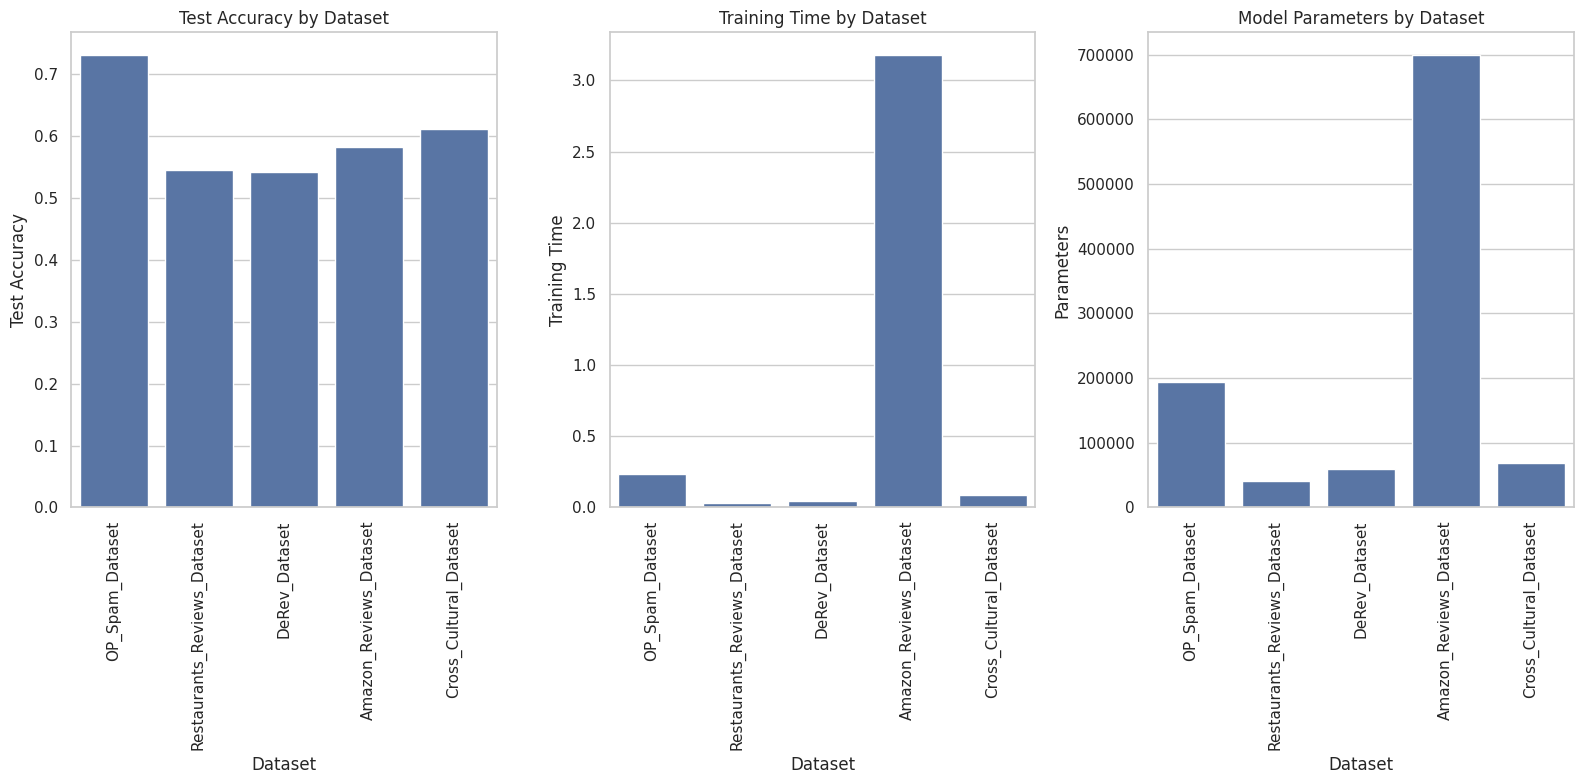

Vocab()

Model:
TransformerModel(
  (embedding): Embedding(1622, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc): Linear(in_features=100, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)
Total parameters:  209194



Epoch: 1


100%|██████████| 38/38 [00:00<00:00, 57.89it/s]


Train Loss : 0.672
Valid Loss : 0.662 Valid Acc  : 0.594
Epoch: 2


100%|██████████| 38/38 [00:00<00:00, 99.43it/s]


Train Loss : 0.609
Valid Loss : 0.646 Valid Acc  : 0.594
Epoch: 3


100%|██████████| 38/38 [00:00<00:00, 90.36it/s]


Train Loss : 0.515
Valid Loss : 0.633 Valid Acc  : 0.719
Epoch: 4


100%|██████████| 38/38 [00:00<00:00, 106.17it/s]


Train Loss : 0.430
Valid Loss : 0.727 Valid Acc  : 0.641
Epoch: 5


100%|██████████| 38/38 [00:00<00:00, 145.10it/s]


Train Loss : 0.331
Valid Loss : 0.752 Valid Acc  : 0.688
Epoch: 6


100%|██████████| 38/38 [00:00<00:00, 132.50it/s]


Train Loss : 0.259
Valid Loss : 0.915 Valid Acc  : 0.672
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.688
Precision (Weighted): 0.689
Recall (Weighted): 0.688
F1-Score (Weighted): 0.687
Balanced Accuracy: 0.688

Classification Report : 
              precision    recall  f1-score   support

           0       0.67      0.74      0.70       160
           1       0.71      0.64      0.67       160

    accuracy                           0.69       320
   macro avg       0.69      0.69      0.69       320
weighted avg       0.69      0.69      0.69       320


Confusion Matrix : 
[[118  42]
 [ 58 102]]
209194, 0.2932548522949219, 0.6875
Vocab()

Model:
TransformerModel(
  (embedding): Embedding(84, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): Linear(in_features

100%|██████████| 3/3 [00:00<00:00, 130.95it/s]


Train Loss : 0.700
Valid Loss : 0.697 Valid Acc  : 0.200
Epoch: 2


100%|██████████| 3/3 [00:00<00:00, 111.60it/s]


Train Loss : 0.691
Valid Loss : 0.705 Valid Acc  : 0.400
Epoch: 3


100%|██████████| 3/3 [00:00<00:00, 123.49it/s]


Train Loss : 0.688
Valid Loss : 0.716 Valid Acc  : 0.400
Epoch: 4


100%|██████████| 3/3 [00:00<00:00, 124.30it/s]


Train Loss : 0.681
Valid Loss : 0.711 Valid Acc  : 0.400
Epoch: 5


100%|██████████| 3/3 [00:00<00:00, 126.66it/s]


Train Loss : 0.671
Valid Loss : 0.703 Valid Acc  : 0.400
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.636
Precision (Weighted): 0.694
Recall (Weighted): 0.636
F1-Score (Weighted): 0.607
Balanced Accuracy: 0.636

Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.59      0.91      0.71        11

    accuracy                           0.64        22
   macro avg       0.69      0.64      0.61        22
weighted avg       0.69      0.64      0.61        22


Confusion Matrix : 
[[ 4  7]
 [ 1 10]]
55394, 0.032308101654052734, 0.6363636363636364
Vocab()

Model:
TransformerModel(
  (embedding): Embedding(280, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): Linear(i

100%|██████████| 6/6 [00:00<00:00, 132.33it/s]


Train Loss : 0.693
Valid Loss : 0.706 Valid Acc  : 0.300
Epoch: 2


100%|██████████| 6/6 [00:00<00:00, 124.35it/s]


Train Loss : 0.677
Valid Loss : 0.712 Valid Acc  : 0.300
Epoch: 3


100%|██████████| 6/6 [00:00<00:00, 123.80it/s]


Train Loss : 0.641
Valid Loss : 0.702 Valid Acc  : 0.500
Epoch: 4


100%|██████████| 6/6 [00:00<00:00, 139.43it/s]


Train Loss : 0.562
Valid Loss : 0.756 Valid Acc  : 0.500
Epoch: 5


100%|██████████| 6/6 [00:00<00:00, 119.28it/s]

Train Loss : 0.485
Valid Loss : 0.732 Valid Acc  : 0.600
Epoch:

 6


100%|██████████| 6/6 [00:00<00:00, 98.70it/s]


Train Loss : 0.361
Valid Loss : 0.853 Valid Acc  : 0.500
Epoch: 7


100%|██████████| 6/6 [00:00<00:00, 95.53it/s]


Train Loss : 0.281
Valid Loss : 0.777 Valid Acc  : 0.600
Epoch: 8


100%|██████████| 6/6 [00:00<00:00, 98.43it/s]


Train Loss : 0.188
Valid Loss : 0.980 Valid Acc  : 0.600
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.583
Precision (Weighted): 0.584
Recall (Weighted): 0.583
F1-Score (Weighted): 0.583
Balanced Accuracy: 0.583

Classification Report : 
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        24
           1       0.59      0.54      0.57        24

    accuracy                           0.58        48
   macro avg       0.58      0.58      0.58        48
weighted avg       0.58      0.58      0.58        48


Confusion Matrix : 
[[15  9]
 [11 13]]
74994, 0.07122921943664551, 0.5833333333333334
Vocab()

Model:
TransformerModel(
  (embedding): Embedding(6675, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): Linear(i

100%|██████████| 499/499 [00:02<00:00, 192.80it/s]


Train Loss : 0.690
Valid Loss : 0.688 Valid Acc  : 0.552
Epoch: 2


100%|██████████| 499/499 [00:02<00:00, 189.69it/s]


Train Loss : 0.668
Valid Loss : 0.681 Valid Acc  : 0.588
Epoch: 3


100%|██████████| 499/499 [00:02<00:00, 191.62it/s]


Train Loss : 0.628
Valid Loss : 0.687 Valid Acc  : 0.577
Epoch: 4


100%|██████████| 499/499 [00:03<00:00, 135.19it/s]


Train Loss : 0.573
Valid Loss : 0.719 Valid Acc  : 0.571
Epoch: 5


100%|██████████| 499/499 [00:02<00:00, 174.08it/s]


Train Loss : 0.502
Valid Loss : 0.779 Valid Acc  : 0.588
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.575
Precision (Weighted): 0.576
Recall (Weighted): 0.575
F1-Score (Weighted): 0.574
Balanced Accuracy: 0.575

Classification Report : 
              precision    recall  f1-score   support

           0       0.58      0.52      0.55      2100
           1       0.57      0.63      0.60      2100

    accuracy                           0.58      4200
   macro avg       0.58      0.58      0.57      4200
weighted avg       0.58      0.58      0.57      4200


Confusion Matrix : 
[[1098 1002]
 [ 781 1319]]
714494, 2.875983953475952, 0.5754761904761905
Vocab()

Model:
TransformerModel(
  (embedding): Embedding(368, 100)
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (fc_out): Li

100%|██████████| 15/15 [00:00<00:00, 173.73it/s]


Train Loss : 0.693
Valid Loss : 0.676 Valid Acc  : 0.600
Epoch: 2


100%|██████████| 15/15 [00:00<00:00, 171.54it/s]


Train Loss : 0.685
Valid Loss : 0.705 Valid Acc  : 0.400
Epoch: 3


100%|██████████| 15/15 [00:00<00:00, 173.75it/s]


Train Loss : 0.646
Valid Loss : 0.672 Valid Acc  : 0.520
Epoch: 4


100%|██████████| 15/15 [00:00<00:00, 153.75it/s]


Train Loss : 0.556
Valid Loss : 0.701 Valid Acc  : 0.520
Early stopping: No improvement for 3 consecutive epochs.

Test Accuracy : 0.595
Precision (Weighted): 0.612
Recall (Weighted): 0.595
F1-Score (Weighted): 0.581
Balanced Accuracy: 0.597

Classification Report : 
              precision    recall  f1-score   support

           0       0.57      0.78      0.66        60
           1       0.66      0.41      0.51        61

    accuracy                           0.60       121
   macro avg       0.61      0.60      0.58       121
weighted avg       0.61      0.60      0.58       121


Confusion Matrix : 
[[47 13]
 [36 25]]
83794, 0.10747432708740234, 0.5950413223140496

Results DataFrame for Transformer Model:
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      209194       0.293255       0.687500   
1  Restaurants_Reviews_Dataset       55394       0.032308       0.636364   
2                DeRev_Dataset       74994      

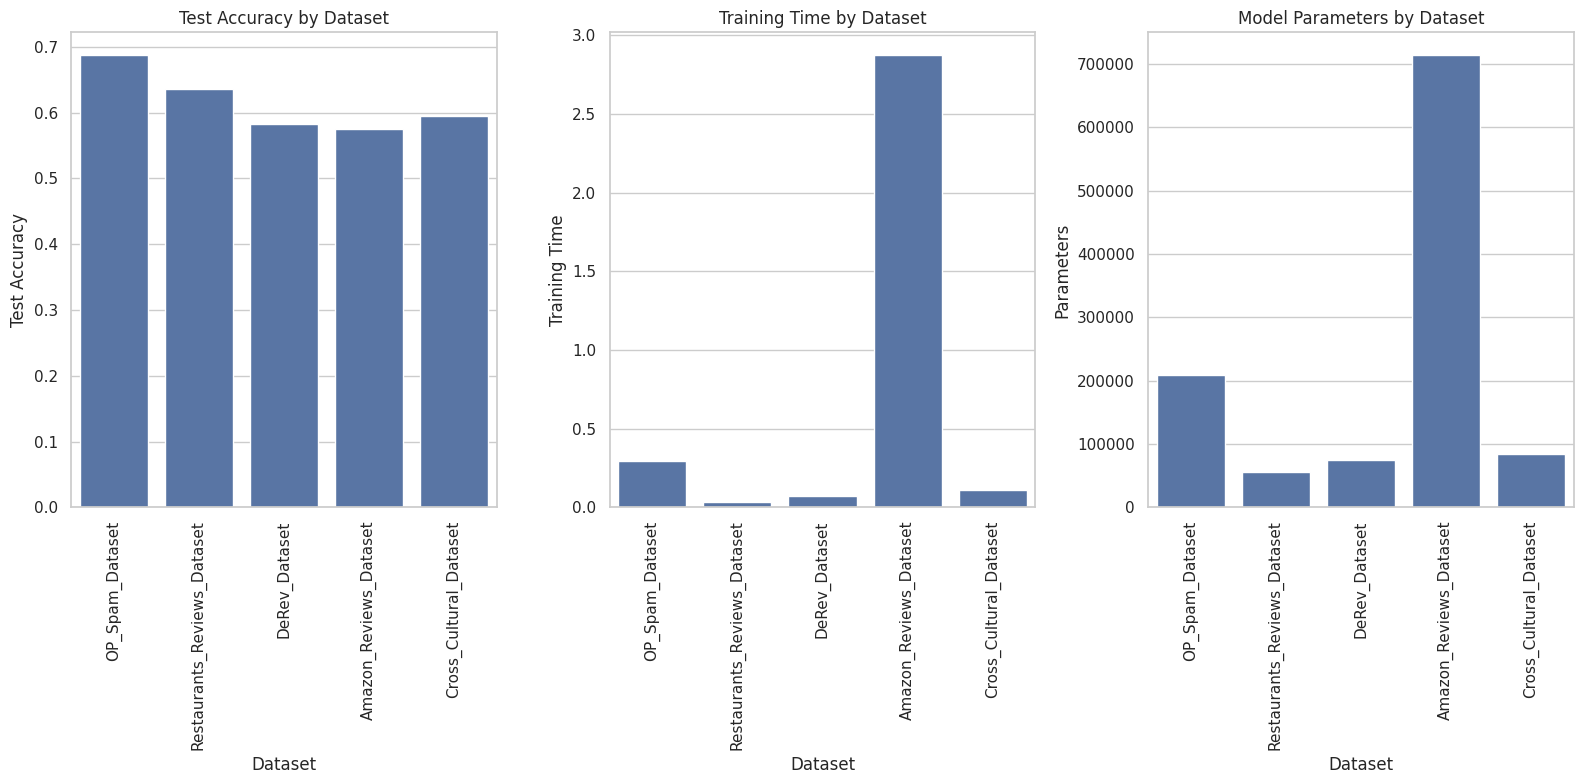

In [ ]:
rnn_results_df = run_experiment(dataset_loaders, RNNModel, "RNN Model", 3, False)
birnn_results_df = run_experiment(dataset_loaders, BiRNNModel, "BiRNN Model", 3, False)
lstm_results_df = run_experiment(dataset_loaders, LSTMModel, "LSTM Model", 3, False)
gru_results_df = run_experiment(dataset_loaders, GRUModel, "GRU Model", 3, False)
transformer_results_df= run_experiment(dataset_loaders, TransformerModel, "Transformer Model", 3, True)

In [ ]:
print(rnn_results_df)
print(birnn_results_df)
print(lstm_results_df)
print(gru_results_df)
print(transformer_results_df)

                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      172954       0.383624       0.487500   
1  Restaurants_Reviews_Dataset       19154       0.031631       0.590909   
2                DeRev_Dataset       38754       0.083083       0.520833   
3       Amazon_Reviews_Dataset      678254       1.973258       0.506429   
4       Cross_Cultural_Dataset       47554       0.071696       0.520661   

   Precision    Recall  F1-Score  Balanced Accuracy  
0   0.486833  0.487500  0.480931           0.487500  
1   0.775000  0.590909  0.508685           0.590909  
2   0.524242  0.520833  0.503374           0.520833  
3   0.508470  0.506429  0.474780           0.506429  
4   0.520568  0.520661  0.517030           0.519945  
                       Dataset  Parameters  Training Time  Test Accuracy  \
0              OP_Spam_Dataset      183706       0.364498       0.525000   
1  Restaurants_Reviews_Dataset       29906       0.037641       0.7

In [ ]:
import pandas as pd

# Add a 'Model' column to each DataFrame
rnn_results_df['Model'] = 'RNN Model'
birnn_results_df['Model'] = 'BiRNN Model'
lstm_results_df['Model'] = 'LSTM Model'
gru_results_df['Model'] = 'GRU Model'
transformer_results_df['Model'] = 'Transformer Model'

# List of DataFrames to concatenate
dataframes = [rnn_results_df, birnn_results_df, lstm_results_df, gru_results_df, transformer_results_df]

# Concatenate the DataFrames along rows (axis=0)
combined_results_df = pd.concat(dataframes, axis=0, ignore_index=True)

# Print the combined DataFrame to verify
print(combined_results_df)


                        Dataset  Parameters  Training Time  Test Accuracy  \
0               OP_Spam_Dataset      172954       0.383624       0.487500   
1   Restaurants_Reviews_Dataset       19154       0.031631       0.590909   
2                 DeRev_Dataset       38754       0.083083       0.520833   
3        Amazon_Reviews_Dataset      678254       1.973258       0.506429   
4        Cross_Cultural_Dataset       47554       0.071696       0.520661   
5               OP_Spam_Dataset      183706       0.364498       0.525000   
6   Restaurants_Reviews_Dataset       29906       0.037641       0.727273   
7                 DeRev_Dataset       49506       0.054775       0.604167   
8        Amazon_Reviews_Dataset      689006       2.096854       0.533095   
9        Cross_Cultural_Dataset       58306       0.084011       0.471074   
10              OP_Spam_Dataset      204826       0.361930       0.709375   
11  Restaurants_Reviews_Dataset       51026       0.024877       0.590909   

In [ ]:
combined_results_df.to_csv('in_domain_full_results.csv')